<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/ADRpy_splash.png" width="40%" align="left">

*Given a general layout (perhaps one of several candidates at this stage) and some idea of the maximum take-off weight, the next major step of the conceptual design process is the constraint analysis, which will yield the required wing area and thrust - effectively giving 'scale' to the concept.*

*The constraint analysis establishes the boundaries of the feasible part of the thrust to weight ratio (T/W) versus wing loading (W/S) space. Each element of the mission of the aircraft 'bites out' a chunk from this space and the aeroplane we progress to the subsequent stages of the design process will have to 'live' in the remaining subspace - generally at the lowest thrust/smallest wing point of the remaining feasible chunk.*

*This notebook is designed to walk the reader through ADRpy's constraint analysis capabilities in the context of an example, that of a single piston engine, propeller driven aircraft.*

In [18]:
import matplotlib.pyplot as plt
import numpy as np

from ADRpy import atmospheres as at
from ADRpy import constraintanalysis as ca
from ADRpy import takeoffroll as tr
from ADRpy import unitconversions as co

# Constraint Analysis in ADRpy - a Single Engine Piston Prop Example

Let us consider the wing and propulsion sizing problem of a single engine piston prop. We base this example broadly on the design brief, geometry and performance figures of the Cirrus SR-22, as presented in [1].

First, we set up a dictionary variable containing elements of the design brief. 

Each row refers to a specific constraint: take-off, turn, climb, cruise, service ceiling.

The dictionary entry ``cruisethrustfact`` defines the throttle setting expected to be used in cruise (1 = full throttle).

All of the requirements below refer to ISA standard day conditions (see the documentation for the ``Atmosphere`` class for how to instantiate other atmospheres) and we create an ``Atmosphere`` class variable to specify this. 

In [19]:
designbrief = {'rwyelevation_m':0, 'groundrun_m':313, # <- Take-off requirements
               'stloadfactor': 1.5, 'turnalt_m': 1000, 'turnspeed_ktas': 100, # <- Turn requirements
               'climbalt_m': 0, 'climbspeed_kias': 101, 'climbrate_fpm': 1398, # <- Climb requirements
               'cruisealt_m': 3048, 'cruisespeed_ktas': 182, 'cruisethrustfact': 1.0, # <- Cruise requirements
               'servceil_m': 6580, 'secclimbspd_kias': 92, # <- Service ceiling requirements
               'vstallclean_kcas': 69} # <- Required clean stall speed

designatm = at.Atmosphere()

Next we specify our current take-off weight estimate. During the design process, as the generative weight model of the aircraft becomes increasingly accurate, this should be updated accordingly (along with all the other dictionaries).

In [20]:
TOW_kg = 1542.0

Basic design parameters are specified in the ``designdefinition`` dictionary: aspect ratio, leading edge sweep, sweep of the maximum thickness line of the wing, the engine bypass ratio ('-1' indicates 'piston engine', though this input will be deprecated in a future version of ADRpy, to be replaced by the ``designpropulsion`` input).

Some constraints may not have to be satisfied at MTOW - ``weightfractions`` specifies the weight fraction corresponding to each constraint.

In [21]:
designdefinition = {'aspectratio':10.12, 'sweep_le_deg':2, 'sweep_mt_deg':0,
                    'weightfractions': {'turn': 1.0, 'climb': 1.0, 'cruise': 0.853, 'servceil': 1.0},
                    'weight_n': co.kg2n(TOW_kg)}

designpropulsion = "piston"

We next define some design performance estimates, e.g., the propeller efficiencies ($\eta_\mathrm{prop}$) corresponding to the various constraints, drag and lift coefficients and the wheel rolling resistance coefficient:

In [22]:
designperformance = {'CDTO': 0.0414, 'CLTO': 0.59, 'CLmaxTO': 1.69, 'CLmaxclean': 1.45, 'mu_R': 0.02,
                    'CDminclean': 0.0254,
                    'etaprop': {'take-off': 0.65, 'climb': 0.8, 'cruise': 0.85, 'turn': 0.85, 'servceil': 0.8}}


Everything is now ready for the instantiation of an aircraft concept object, which will serve as the input to the constraint analysis:

In [23]:
concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm, designpropulsion)


### Plotting the constraint diagram - the quickest way

Here is how to get a quick, clean result: define a range of wing loadings (in Pascal) over which you want to perform the constraint analysis and call ``propulsionsensitivity_monothetic``. The name refers to the sensitivity analysis capabilities of this high level wrapper method, but, for now, we'll just use it to generate the basic constraint diagram:

In [24]:
wslist_pa = np.arange(700, 1600, 2.5)

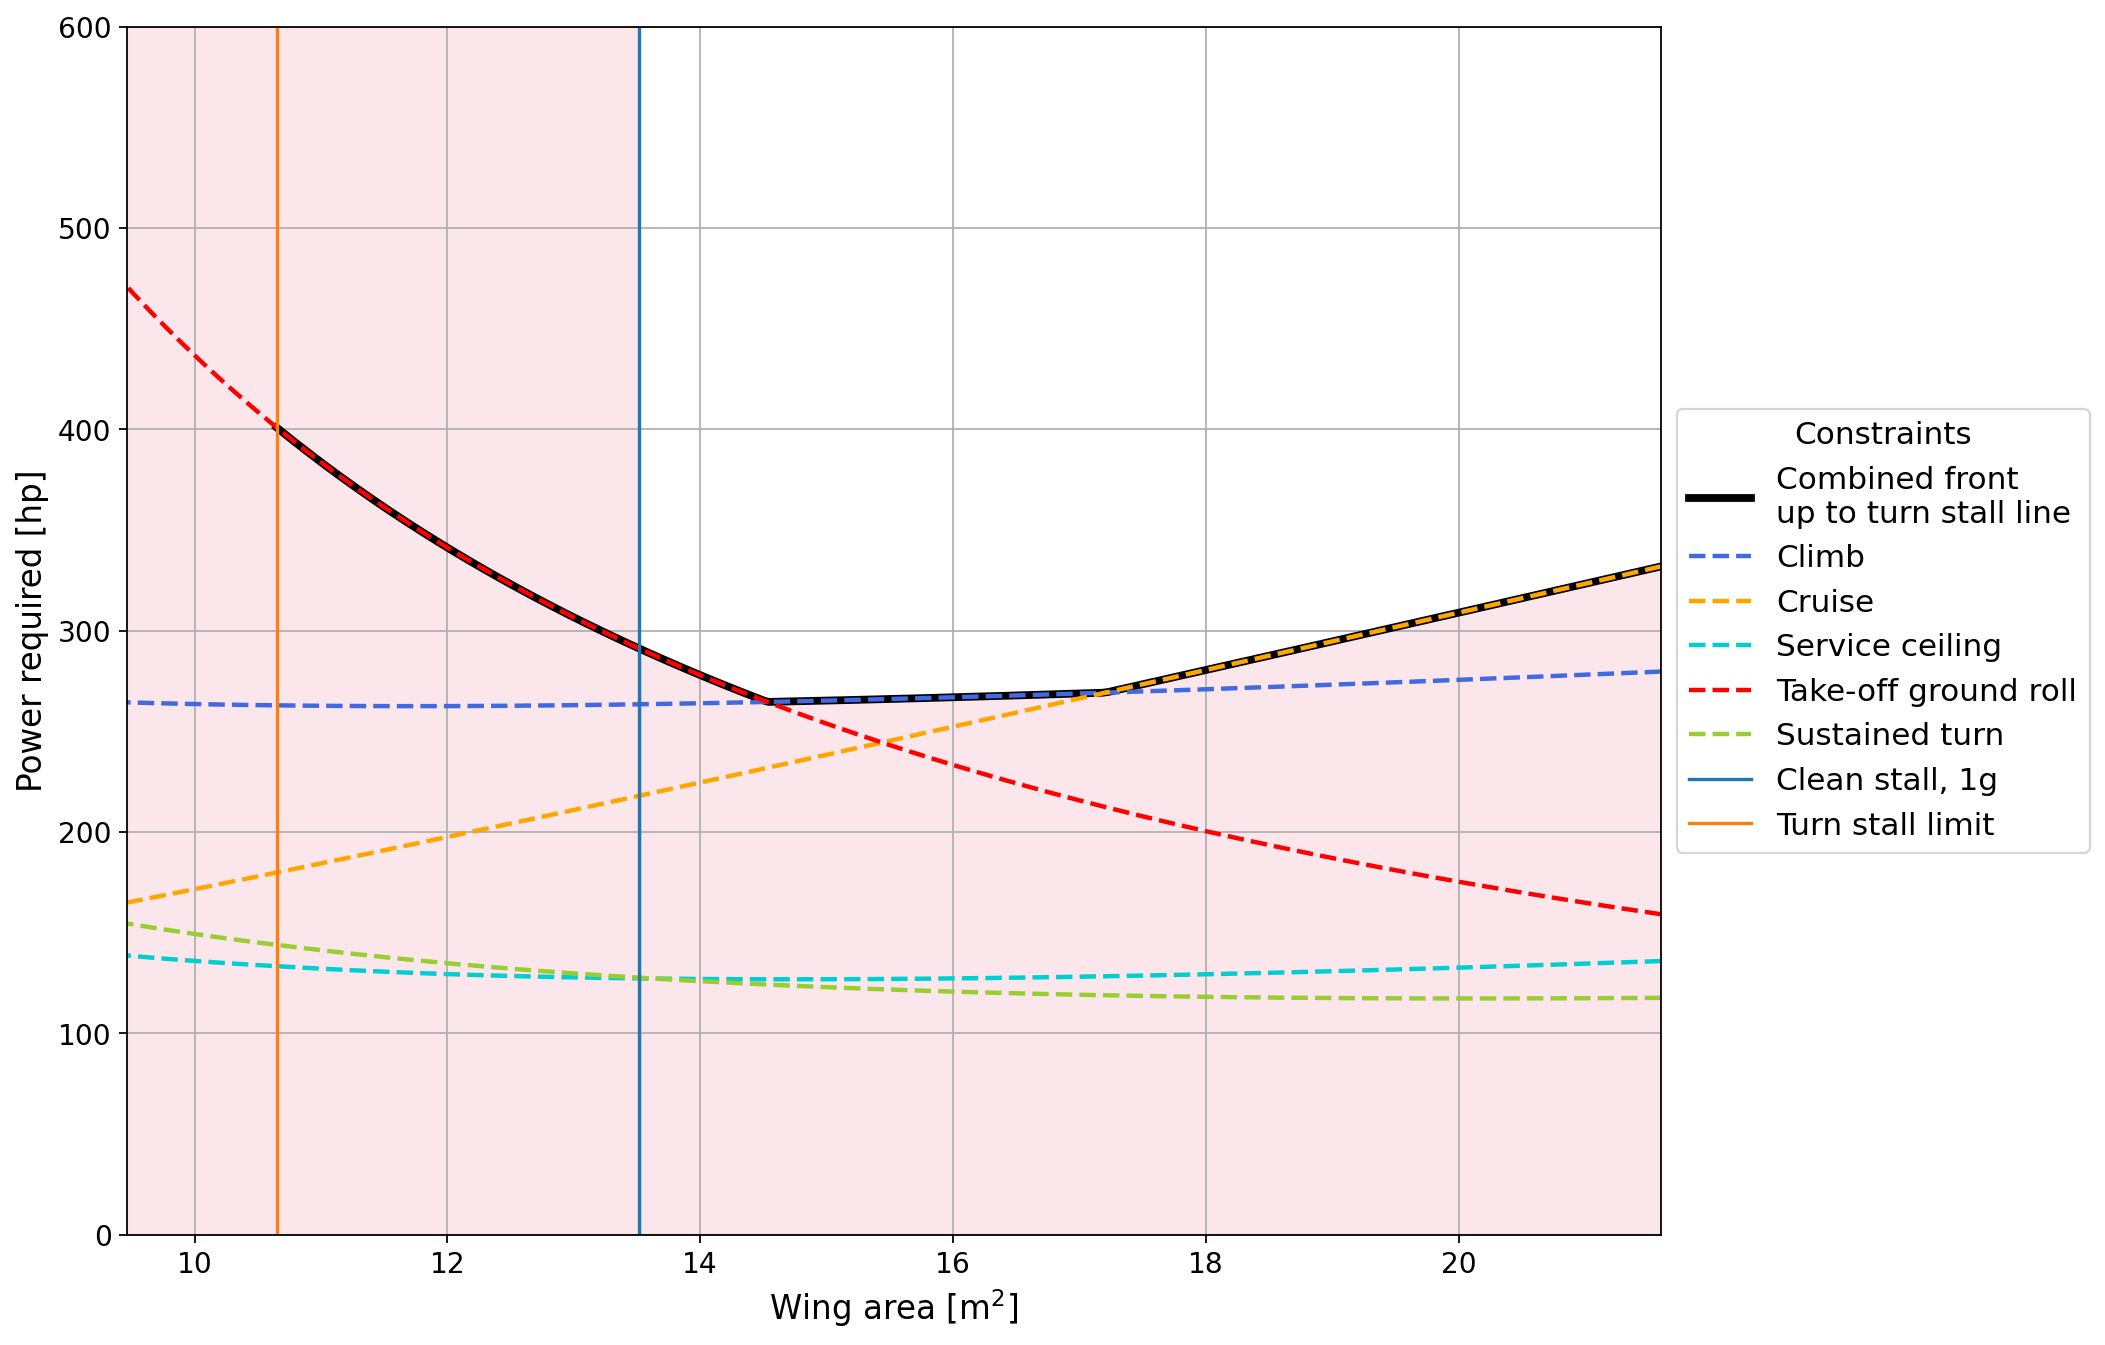

In [25]:
a = concept.propulsionsensitivity_monothetic(wingloading_pa=wslist_pa, show='combined', y_var='p_hp', x_var='s_m2', y_lim=600)

Note that, as expected, the actual aircraft (the Cirrus SR-22), with its 310HP Continental IO-550-N engine and 13.5m$^2$ wing area, falls into the bottom left corner of the feasible region.

Just as easily we can inspect the same graph in terms of thrust to weight ratio and wing loading:

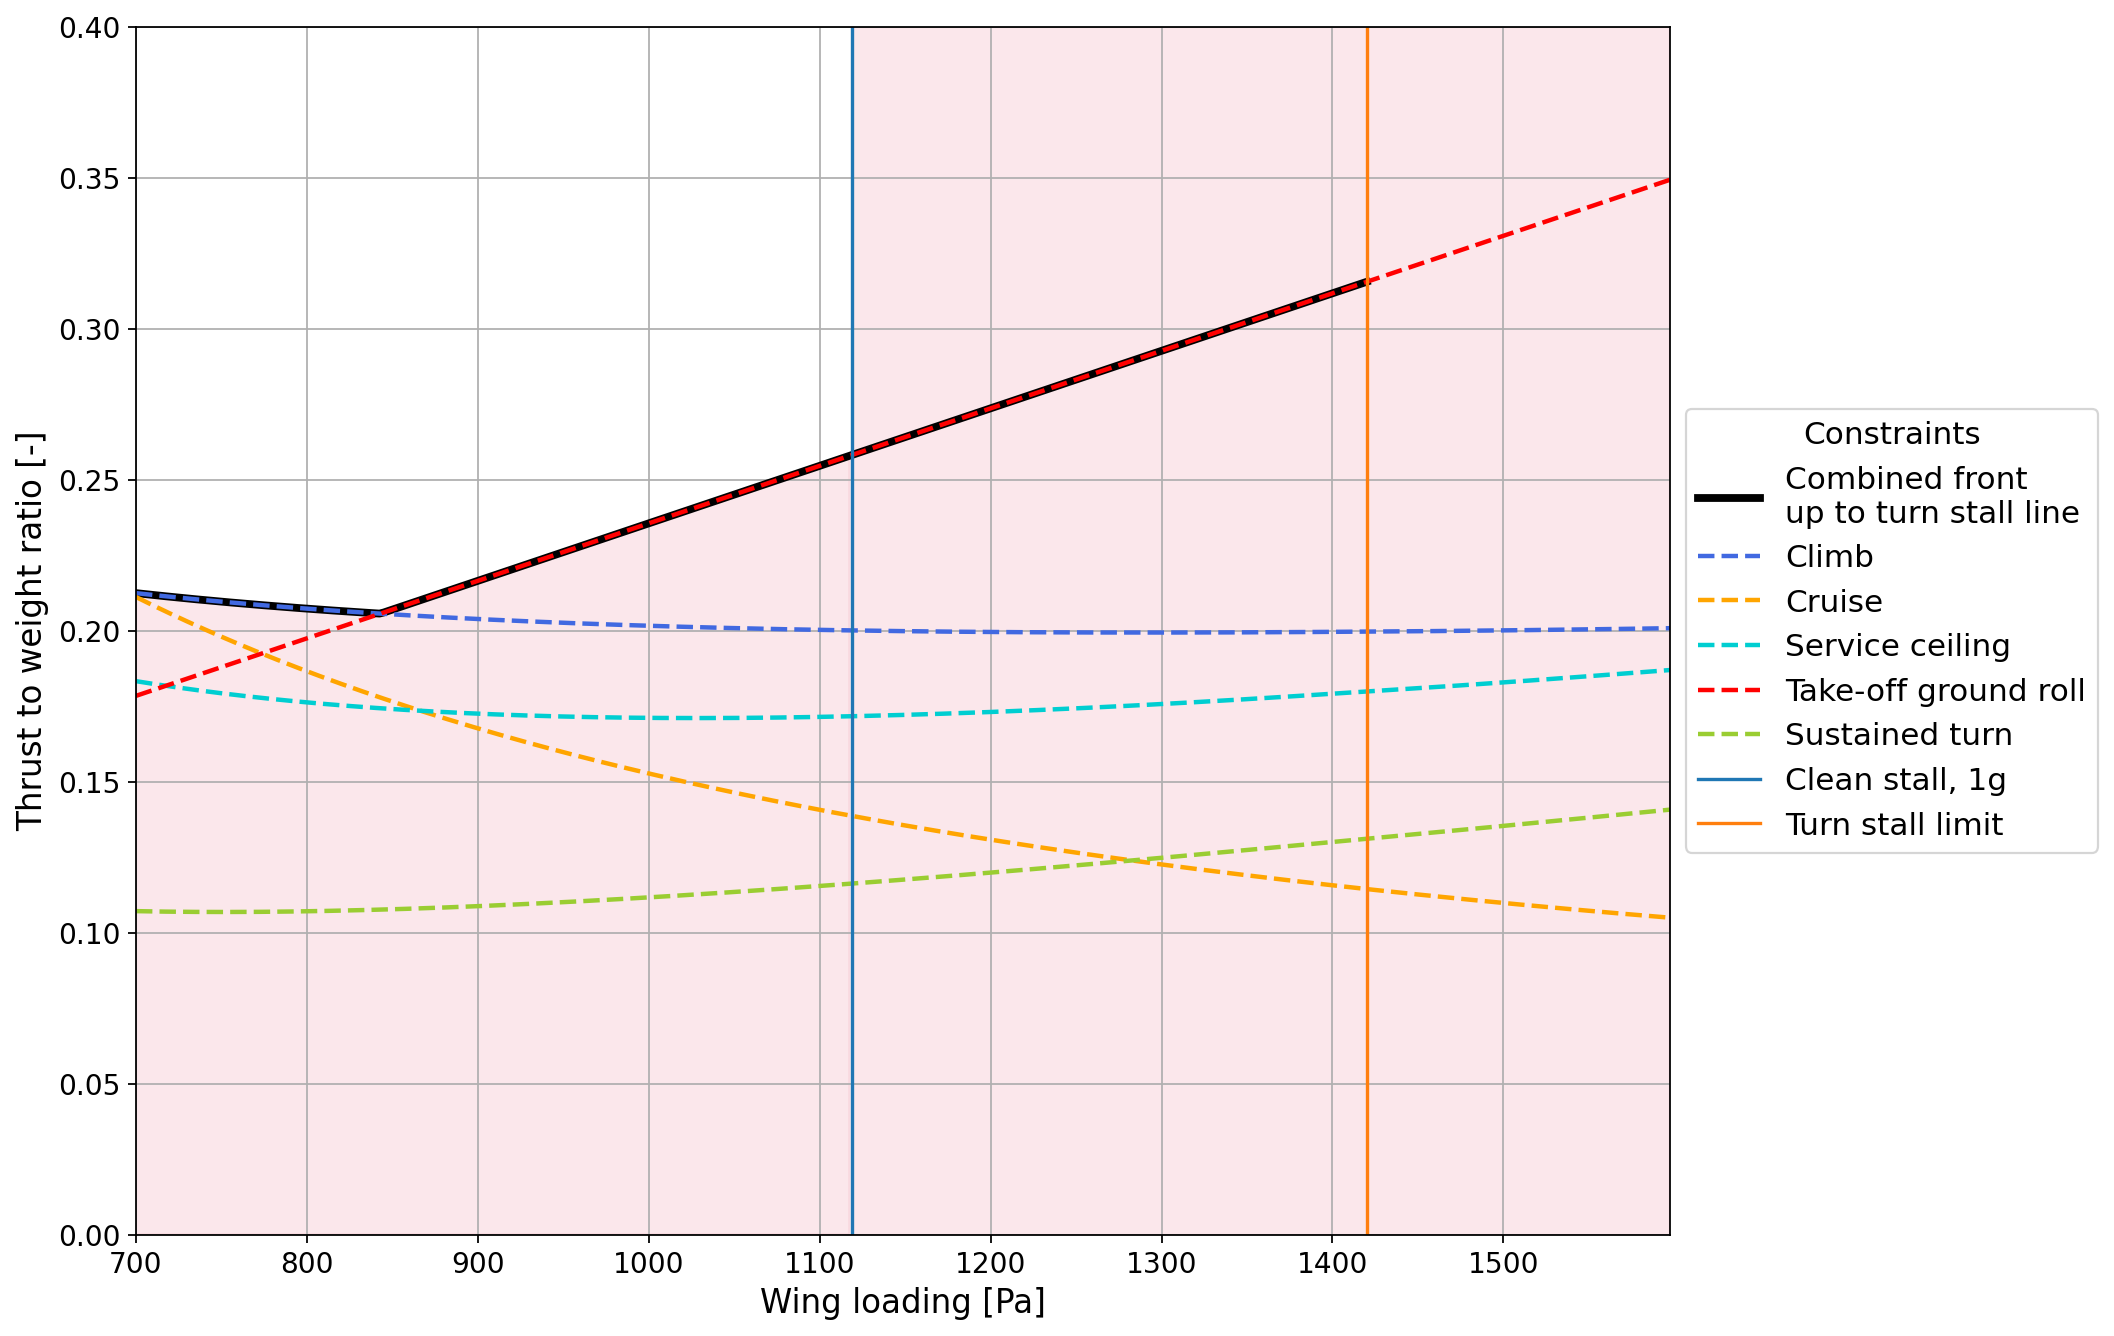

In [26]:
a = concept.propulsionsensitivity_monothetic(wingloading_pa=wslist_pa, show='combined', y_var='tw', x_var='ws_pa', y_lim=0.4)

### Plotting the constraint diagram - the most flexible way

The method demonstrated above creates a constraint diagram (and has other functionality too, as we shall see shortly), but what if the engineer wishes to present the constraints in a different way, perhaps add additional constraints (e.g., constraints computed at different altitudes, weights, etc.)?

The solution is to 'unwrap' the constraint calculations:

In [27]:
preq = concept.powerrequired(wslist_pa, TOW_kg) 

Smin_m2 = concept.smincleanstall_m2(TOW_kg)

We can now generate a plot of the various constraint curves in the power versus wing area space:

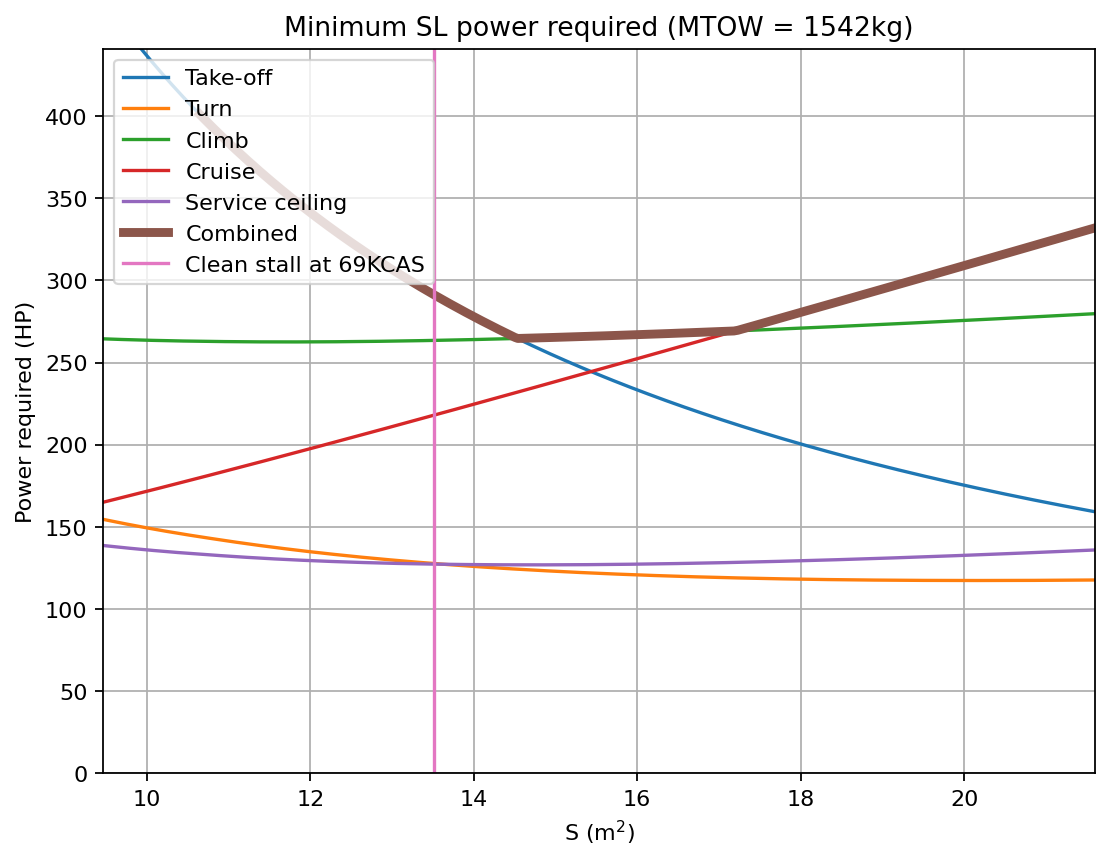

In [28]:
wingarea_m2 = co.kg2n(TOW_kg) / wslist_pa # x axis

plt.rcParams["figure.figsize"] = [8,6]
plt.rcParams['figure.dpi'] = 160

plt.plot(wingarea_m2, preq['take-off'],  label = 'Take-off')
plt.plot(wingarea_m2, preq['turn'], label = 'Turn')
plt.plot(wingarea_m2, preq['climb'], label = 'Climb')
plt.plot(wingarea_m2, preq['cruise'], label = 'Cruise')
plt.plot(wingarea_m2, preq['servceil'], label = 'Service ceiling')

combplot = plt.plot(wingarea_m2, preq['combined'], label = 'Combined')

plt.setp(combplot, linewidth=4)

stall_label = 'Clean stall at ' + str(designbrief['vstallclean_kcas']) + 'KCAS'

plt.plot([Smin_m2, Smin_m2], [0, 1500], label = stall_label)

legend = plt.legend(loc='upper left')

plt.ylabel("Power required (HP)")
plt.xlabel("S (m$^2$)")
plt.title("Minimum SL power required (MTOW = " + str(round(TOW_kg)) + "kg)")
plt.xlim(min(wingarea_m2), max(wingarea_m2))
plt.ylim(0, max(preq['combined']) * 1.1)
plt.grid(True)
plt.show()

### Constraint sensitivity analysis

The constraint diagram reveals the shape of the feasible design space for a single set of design variables and constraints (as set out by the design brief). It does not tell us, however, how sensitive the shape and size of the feasible design space is to changes in the design variable values and the numbers that make up the design brief. This is where the sensititivity analysis capabilities of the aforementioned `propulsionsensitivity_monothetic` come handy.

Let us first define what we mean by *sensitivity* in this context: given two extreme values of an input, we shall define sensitivity of a constraint (for a given wing area) to that input simply as the absolute difference between the values of the constraint calculated at the two extremes.

We also define (and will plot via `propulsionsensitivity_monothetic`) the *relative sensitivity*, which is the sensitivity described above divided by the sum of all such sensitivities calculated for a particular constraint.

These are both 'one factor at a time' sensitivities, that is, when calculating them we keep everything else fixed (at the midpoints of the ranges given).

The ADRpy implementation of the idea is simple: instead of entering single values into the dictionaries fed into the constraint analysis (as above), the user enters the two extreme values, as a list of two numbers.

Consider the example used earlier, this time in the context of seeking to understand the sensitivities of various constraints to several variables: maximum load factor, the altitude where the turn constraint is specified, the speed at which the turn constraint is specified, the cruise altitude, etc. All the *single* values entered below will be considered fixed, for everything given as a *two element list* we will compute sensitivities.

In [29]:
designbrief = {'rwyelevation_m': 0, 'groundrun_m': 313,
                'stloadfactor': [1.5, 1.65], 'turnalt_m': [1000, 1075], 'turnspeed_ktas': [100, 110],
                'climbalt_m': 0, 'climbspeed_kias': 101, 'climbrate_fpm': 1398,
                'cruisealt_m': [2600, 3200], 'cruisespeed_ktas': [170, 175], 'cruisethrustfact': 1.0,
                'servceil_m': [6500, 6650], 'secclimbspd_kias': 92,
                'vstallclean_kcas': 69}

designdefinition = {'aspectratio': [10, 11], 'sweep_le_deg': 2, 'sweep_25_deg': 0, 'bpr': -1,
                    'weight_n': 15000,
                    'weightfractions': {'turn': 1.0, 'climb': 1.0, 'cruise': 0.853, 'servceil': 1.0}}

designperformance = {'CDTO': 0.0414, 'CLTO': 0.59, 'CLmaxTO': 1.69, 'CLmaxclean': 1.45, 'mu_R': 0.02,
                    'CDminclean': [0.0254, 0.026],
                    'etaprop': {'take-off': 0.65, 'climb': 0.8, 'cruise': 0.85, 'turn': 0.85, 'servceil': 0.8}}

designatm = at.Atmosphere()

designpropulsion = "piston"

As before, we now instantiate the aircraft concept object and set a range of wing loadings that defines the x axes of the plots.

In [30]:
concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm, designpropulsion)
wslist_pa = np.arange(700, 2500, 2.5)

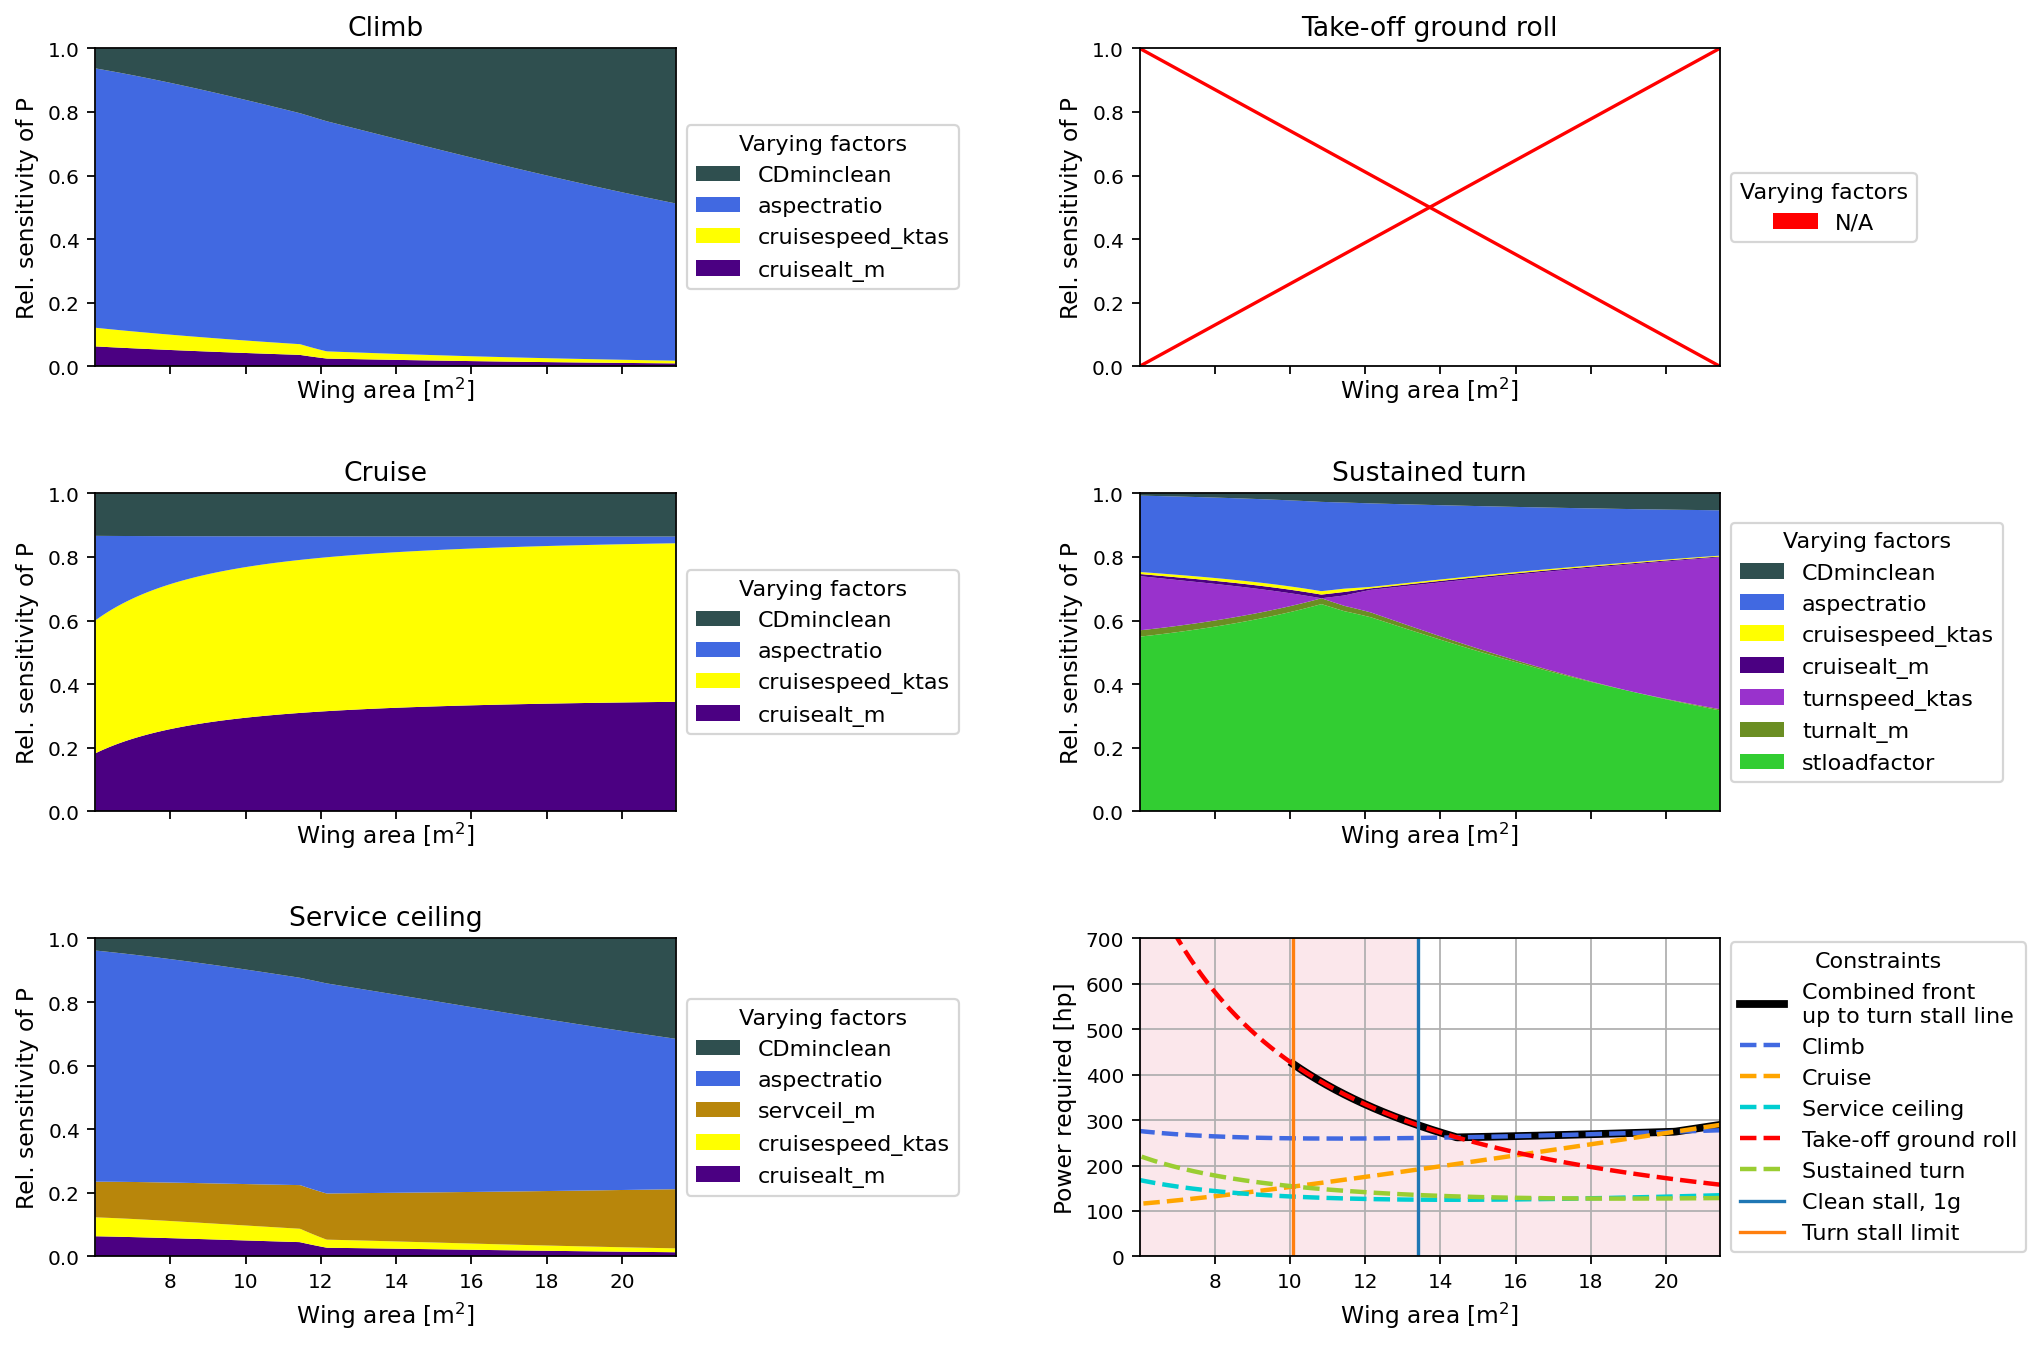

In [31]:
concept.propulsionsensitivity_monothetic(wingloading_pa=wslist_pa, show=True, y_var='p_hp', x_var='s_m2', y_lim=700)

The red 'X' in the take-off ground roll constraint window indicates no sensitivity in that constraint to any of the inputs given as lists of two extreme values.

The combined constraint diagram (bottom right) uses the interval midpoints for those factors given as a sensitivity.

Single constraints can be viewed too, by setting `show` to the name of the desired constraint.

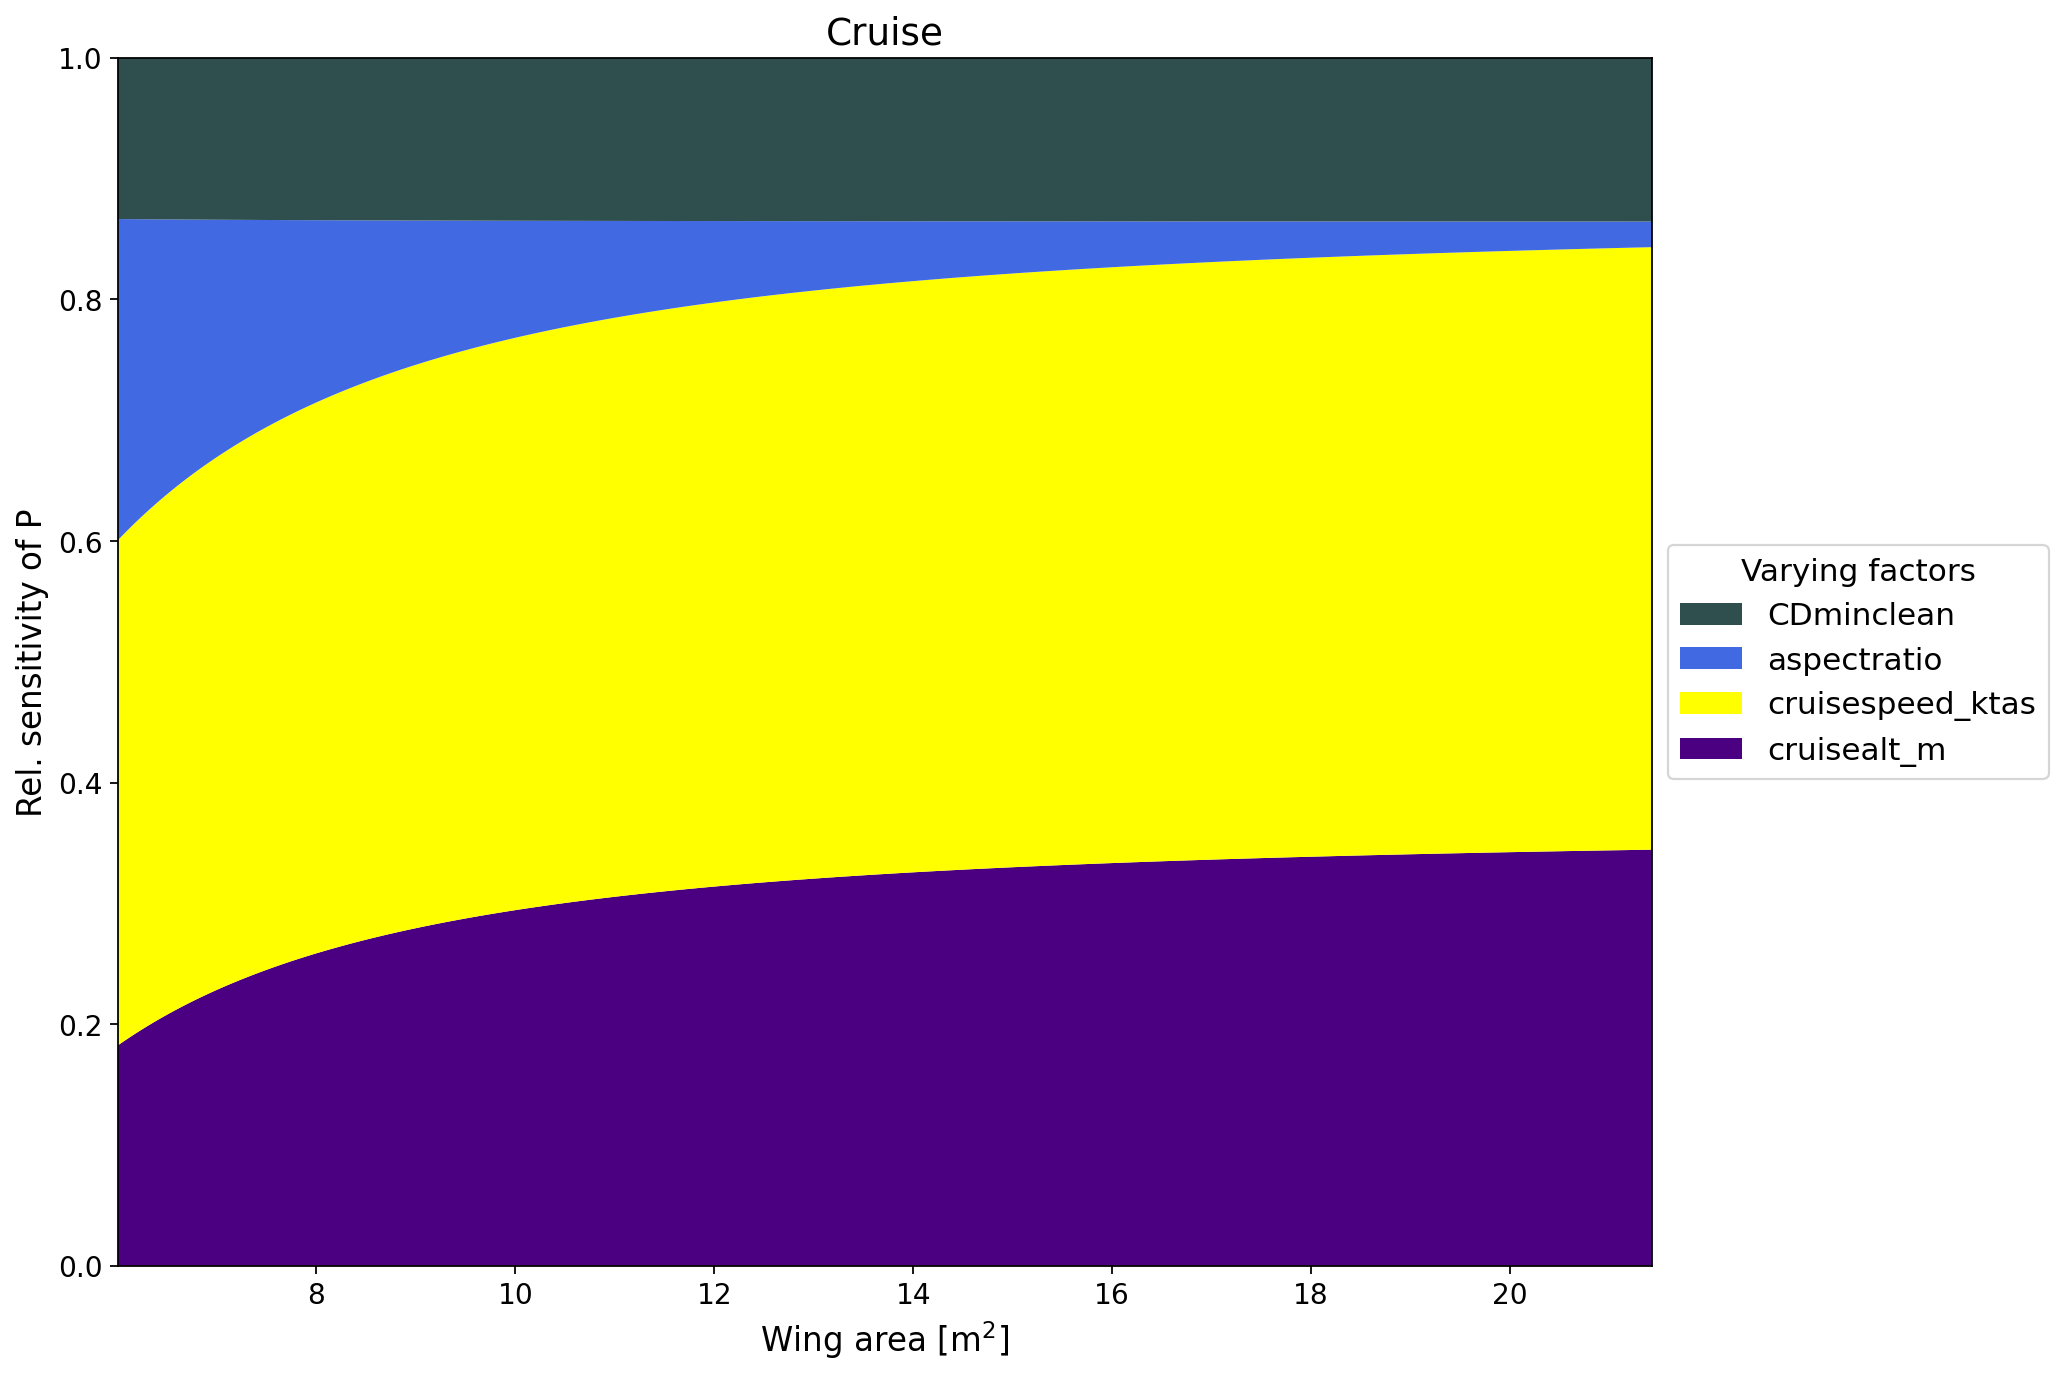

In [32]:
concept.propulsionsensitivity_monothetic(wingloading_pa=wslist_pa, show='cruise', y_var='p_hp', x_var='s_m2', maskbool=False)

## Water Takeoff Run

To determine takeoff distance on water some float paramters must be given. We utilise an Euler-intergration code to
find the lift, drag, hydrodynamic resistance and velocity at time intervals of t_int.


In [33]:
floats = {'beam': 0.635, 'length': 3.81, 'trim_start': 6, 'trim_end': 8}
w_area = 10
Thrust = 7000
t_int = 0.25

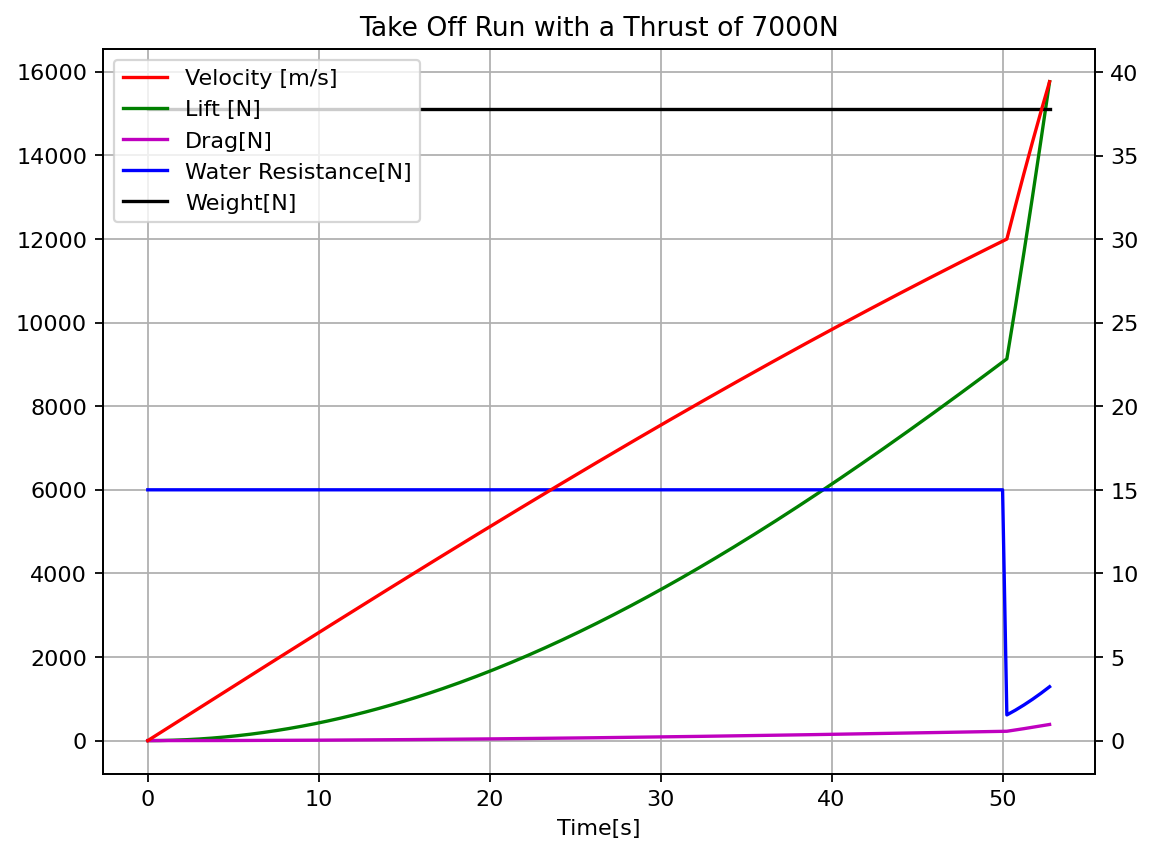

In [34]:
Fplane = tr.Floatplane(TOW_kg, w_area, concept, floats)
water_to = Fplane.TakeOffRun(t_int, Thrust)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax2.plot(water_to['time'], water_to['velocity'],'r', label='Velocity [m/s]',)
lns2 = ax1.plot(water_to['time'], water_to['lift'],'g', label='Lift [N]')
lns3 = ax1.plot(water_to['time'], water_to['drag'],'m', label='Drag[N]')
lns4 = ax1.plot(water_to['time'], water_to['resistance'],'b', label='Water Resistance[N]')
# plt.plot(t_s, R_frs, label='Hydroplaning Resistance [N]')
lns5 = ax1.plot(water_to['time'], water_to['weight'],'k', label='Weight[N]')
lns = lns1+lns2+lns3+lns4+lns5
labs = [l.get_label() for l in lns]
ax1.legend(lns,labs,loc=0)
ax1.set_xlabel('Time[s]')
ax1.grid()
ax1.set_title('Take Off Run with a Thrust of ' + str(Thrust) + 'N')
plt.show()

### References

[1] Gudmundsson, S., "General Aviation Aircraft Design: Applied Methods and Procedures", Butterworth-Heinemann, 2013.